<br>
<h1 style = "font-size:60px; font-family:Monaco ; font-weight : normal; background-color: #000055 ; color : #9999ff; text-align: center; border-radius: 50px 50px;">SETI - Breakthrough Listen<br>Exploratory Data Analysis</h1>
<br>

## Description of problem
The vast distances between stars/galaxies and the dramatic effects of the inverse square law make finding electromagnetic signals of intelligent civilizations a challenging task.  Breakthroughs in machine learning using computer vision and time series analysis are tools that may bring us closer to achieving this goal.  The purpose of this notebook, and the greater experiment that this notebook belongs to is to attempt to push the state of the art ever closer to realizing this goal.

## Seti Breakthrough-Listen Dataset
The purpose of this notebook is to interrogate the dataset and try to better understand SETI's data.  The data consists of "cadence snippets taken from the Green Bank Telescope", which is a digital spectrometer that generates spectrograms using the Fourier Transform technique.  The data represent signal intensity as a function of frequency and time.  

The "Cadence" is described in the "Data Information" section of the competition:  
5 minutes on star “A”, then 5 minutes on star “B”, then back to star “A” for 5 minutes, then “C”, then back to “A”, then finishing with 5 minutes on star “D”. One set of six observations (ABACAD) is referred to as a “cadence”.  

The shape of the data is (6, 273, 256), where 273 represents the time (5 minutes) dimension, and 256 represents the frequency dimension.  


## Overview of this notebook:
- Visualize Samples
- Visualize Dataset Statistics
- 

In [55]:
import os
import math
from glob import glob
from typing import List, Dict, Callable

# Data interrogation/manipulation
import sklearn
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import entropy, kurtosis, skew

### Let's take a look a look at directory structure
(kaggle3811) dan@mcslappy:seti$ ls  
> old_leaky_data  sample_submission.csv  test  train  train_labels.csv  

(kaggle3811) dan@mcslappy:seti$ ls train  
> 0  1  2  3  4  5  6  7  8  9  a  b  c  d  e  f  

(kaggle3811) dan@mcslappy:seti$ ls train/0/|head
> 0000799a2b2c42d.npy  
> 00042890562ff68.npy  
> 0005364cdcb8e5b.npy  

(kaggle3811) dan@mcslappy:seti$ cat train_labels.csv |head  
> id,target  
> 0000799a2b2c42d,0  
> 00042890562ff68,0  
> 0005364cdcb8e5b,0  

#### The first character of each npy file corresponds to the hash listed in *_labels.csv

### Let's take a look at an example of a positive and a negative sample

In [2]:
datadir: str = "/data/data/datasets/seti/"
train_labels: pd.DataFrame = pd.read_csv(os.path.join(datadir, "train_labels.csv"))

In [57]:
train_labels.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [3]:
negative_id: str = train_labels.loc[train_labels["target"]==0].head(1).id.item()
negative_id

'0000799a2b2c42d'

In [4]:
positive_id: str = train_labels.loc[train_labels["target"]==1].head(1).id.item()
positive_id

'0024012d1431fbc'

In [5]:
positive_sample: np.array = np.load(os.path.join(datadir, "train", positive_id[0], f"{positive_id}.npy"))
negative_sample: np.array = np.load(os.path.join(datadir, "train", negative_id[0], f"{negative_id}.npy"))

In [6]:
positive_sample.shape

(6, 273, 256)

## Visualize Samples

In [34]:
def display_cadence(cadence: np.array, target:int, cadence_id: str) -> None:
    for i in range(6):
        plt.figure(figsize=(12, 6))
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {cadence_id} TARGET: {target}", fontsize=16)
        plt.imshow(cadence[i].astype(float), interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        plt.ylabel(ylabel='Time Axis')
        plt.xlabel(xlabel='Freq Axis')
    plt.show()

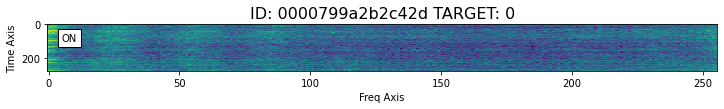

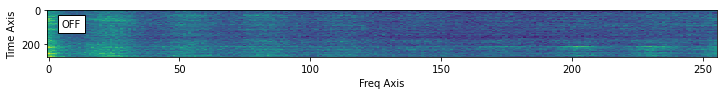

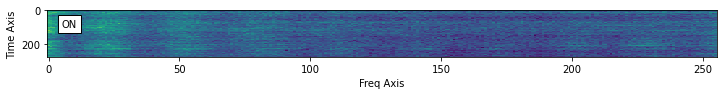

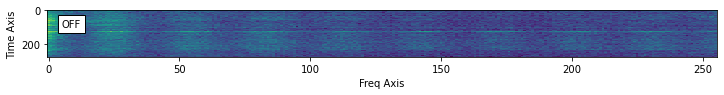

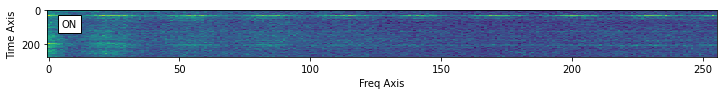

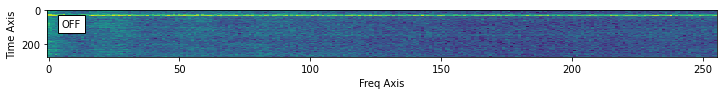

In [35]:
display_cadence(negative_sample, 0, negative_id)

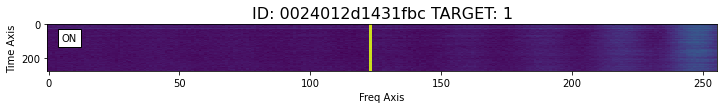

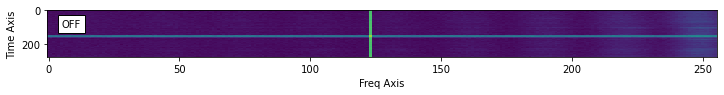

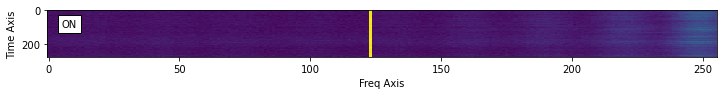

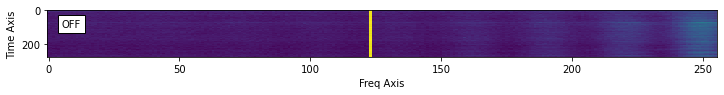

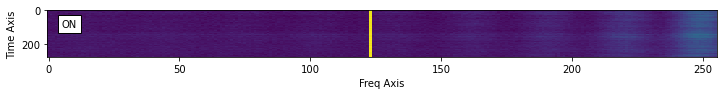

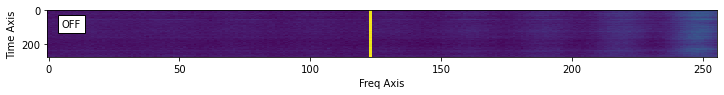

In [36]:
display_cadence(positive_sample, 1, positive_id)

## It seems very difficult to pick out the "needle"
### <font color='red'>Let's look at a few more positive samples</font>

In [37]:
positive_ids = [item[1] for item in train_labels.loc[train_labels["target"]==1].tail(3).id.items()]
positive_ids

['ffdbb03ff1c2e7e', 'ffe5c15a872577d', 'fffbb1c9c3d6c31']

In [38]:
positive_samples = [np.load(os.path.join(datadir, "train", positive_id[1], f"{positive_id}.npy")) for positive_id in positive_ids]

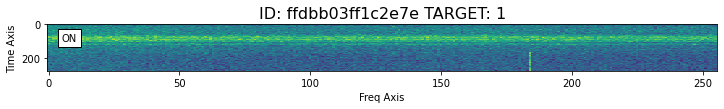

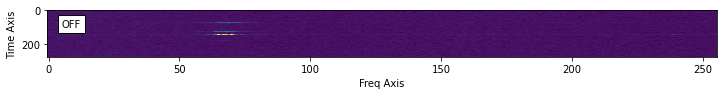

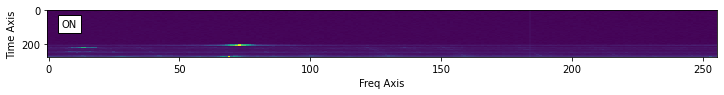

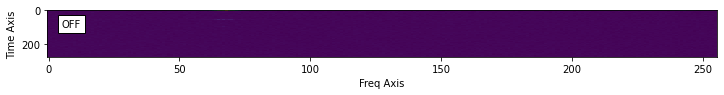

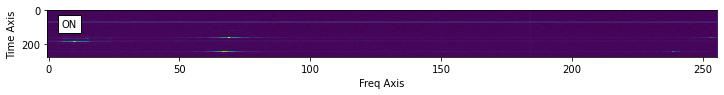

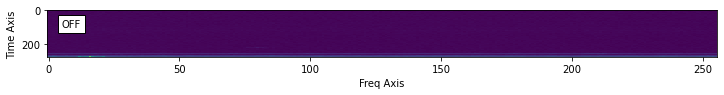

In [39]:
display_cadence(positive_samples[0], 1, positive_ids[0])

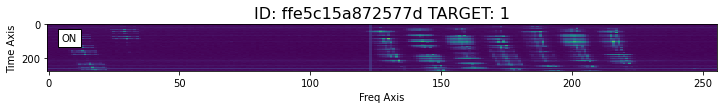

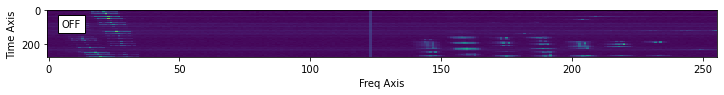

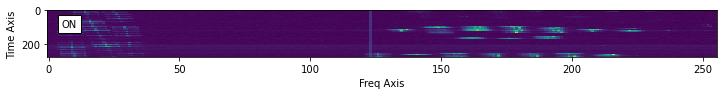

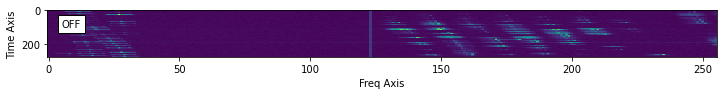

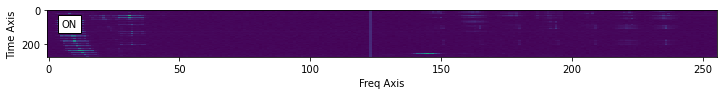

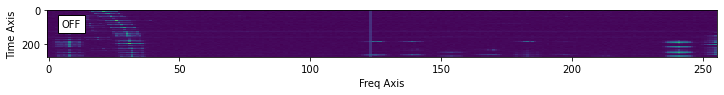

In [40]:
display_cadence(positive_samples[1], 1, positive_ids[1])

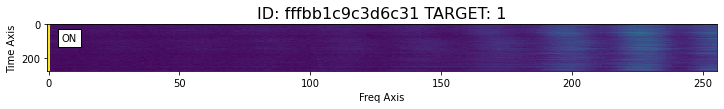

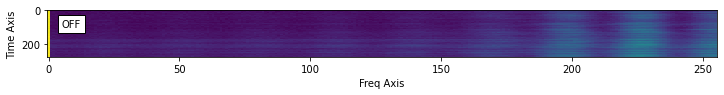

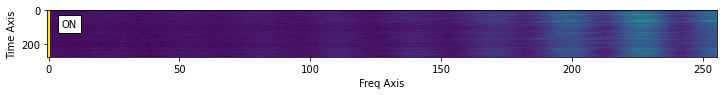

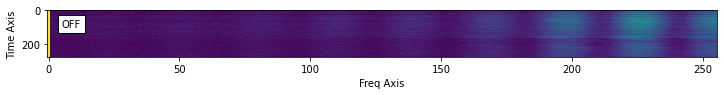

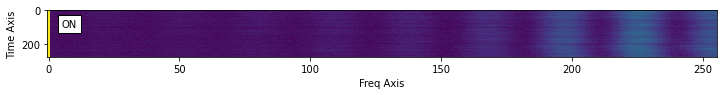

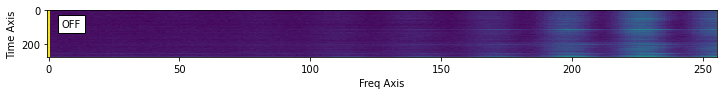

In [41]:
display_cadence(positive_samples[2], 1, positive_ids[2])

### Still difficult to see any visual representation of the positive data

## Visualize Dataset Statistics

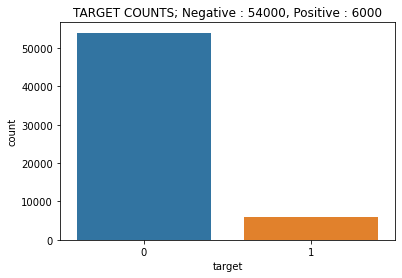

In [33]:
# Histogram the labels
plt.title(f"TARGET COUNTS; Negative : {np.sum(train_labels['target']==0)}, Positive : {np.sum(train_labels['target']==1)}");
sns.countplot(x="target", data=train_labels, label="Labels for training dataset");

### Note that dataset is highly imbalanced
### Next: Look at the statistics of the individual samples
##### <font color='green'>Frequency Binning</font>
Since gathering the statistics of 256 different frequency pixels is laborious and perhaps too fine-grained for our purposes, I will bin the 256 frequency pixels into 8 distinct bins to scan shape (273, 32) of each cadence 

In [49]:
def entropy2(labels: np.array, base: int=None) -> float:
    """
    Computes entropy of label distribution.
    Used because scipy.stats.entropy sometimes fails with NaNs
    """

    n_labels: int = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = math.e if base is None else base
    for i in probs:
        ent -= i * math.log(i, base)

    return ent

In [54]:
# Test entropy2
print(f"Test of 'high entropy': {entropy2(np.array([1,3,2,1,4,4,5,1,2,1]))}")
print(f"Test of 'low entropy': {entropy2(np.array([1,1,1,1,1,4,1,1,1,1]))}")

Test of 'high entropy': 1.4708084763221112
Test of 'low entropy': 0.3250829733914482


In [56]:
stats_functions:  Dict[str, callable] = {
    "mean": np.mean,
    "min": np.min,
    "max": np.max,
    "std": np.std,
    "entropy": entropy2,
    "kurtosis": kurtosis,
    "skew": skew
}    

In [79]:
NUM_FREQ_BINS: int = 8
FREQ_BIN_SIZE: int = 32
train_stats: Dict[str, np.array] = {}
for train_index, train_id in enumerate(train_labels["id"]):
    print(f"\rLoading stats from sample {train_index} : {train_id}", end="")
    sample: np.array = np.load(os.path.join(datadir, "train", train_id[0], f"{train_id}.npy"))
    # (statistic, cadence, frequency_bin)
    stats_arr: np.array = np.empty((7,3,8))
    for cadence_index, cadence in enumerate(sample[0::2]):
        for freq_bin_index in range(NUM_FREQ_BINS):
            freq_bin = cadence[freq_bin_index*FREQ_BIN_SIZE : (freq_bin_index+1)*FREQ_BIN_SIZE]
            for stat_index, stat in enumerate(stats_functions.keys()):
                stats_arr[stat_index, cadence_index, freq_bin_index] = stats_functions[stat](freq_bin.flatten())
    train_stats[train_index] = stats_arr.flatten()

Loading stats from sample 1 : 00042890562ff68

/home/dan/anaconda3/envs/kaggle3811/lib/python3.8/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow encountered in square
  s = s**2


Loading stats from sample 380 : 01a884ca0f278d7

/home/dan/anaconda3/envs/kaggle3811/lib/python3.8/site-packages/scipy/stats/stats.py:1092: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean


Loading stats from sample 59999 : ffff0a799efa529

In [80]:
columns = [f"{stat}_{cadence}_{freq_bin}" for stat in stats_functions.keys() for cadence in range(0,6,2) for freq_bin in range(8)]
print(f"{len(columns)} cols : {columns[:4] + columns[-4:]}")

168 cols : ['mean_0_0', 'mean_0_1', 'mean_0_2', 'mean_0_3', 'skew_4_4', 'skew_4_5', 'skew_4_6', 'skew_4_7']


In [81]:
stats_df = pd.DataFrame.from_dict(train_stats, orient='index', columns=columns)
stats_df.head()

,mean_0_0,mean_0_1,mean_0_2,mean_0_3,mean_0_4,mean_0_5,mean_0_6,mean_0_7,mean_2_0,mean_2_1,...,skew_2_6,skew_2_7,skew_4_0,skew_4_1,skew_4_2,skew_4_3,skew_4_4,skew_4_5,skew_4_6,skew_4_7
0,0.091980,0.421875,0.448730,-0.394287,-0.209595,-0.415039,-0.260498,0.031403,0.157959,0.065674,...,0.773926,0.709473,1.600586,0.482178,0.374756,0.363281,0.594727,0.542969,0.736328,0.977539
1,-0.435303,-0.210938,0.406006,-0.223267,-0.191162,-0.247559,0.534180,0.414307,-0.059265,-0.051361,...,5.574219,5.183594,4.968750,4.390625,4.941406,5.812500,5.558594,5.878906,5.789062,5.351562
2,1.137695,0.663574,0.245972,0.106934,-0.008705,-0.352051,-0.596191,-0.794922,-0.535645,-0.431152,...,0.459961,0.064819,0.059601,0.224731,0.275391,0.434326,0.747559,0.003538,0.650879,0.645996
3,0.503906,0.551270,0.230469,-0.017334,-0.326660,-0.182007,-0.187256,-0.297119,-0.394531,0.431152,...,13.812500,13.515625,12.617188,13.773438,13.664062,13.835938,14.007812,14.250000,14.281250,13.789062
4,-0.150146,-0.255859,-0.192993,-0.077393,0.056183,0.212891,0.636719,-0.127441,-0.038727,0.049225,...,0.330811,-0.120667,2.613281,2.714844,2.332031,2.994141,3.699219,1.438477,1.211914,1.940430


In [85]:
indexes = train_labels['id']

In [86]:
stats_df.index = indexes

In [87]:
stats_df.head()

,mean_0_0,mean_0_1,mean_0_2,mean_0_3,mean_0_4,mean_0_5,mean_0_6,mean_0_7,mean_2_0,mean_2_1,...,skew_2_6,skew_2_7,skew_4_0,skew_4_1,skew_4_2,skew_4_3,skew_4_4,skew_4_5,skew_4_6,skew_4_7
id,,,,,,,,,,,,,,,,,,,,,
0000799a2b2c42d,0.091980,0.421875,0.448730,-0.394287,-0.209595,-0.415039,-0.260498,0.031403,0.157959,0.065674,...,0.773926,0.709473,1.600586,0.482178,0.374756,0.363281,0.594727,0.542969,0.736328,0.977539
00042890562ff68,-0.435303,-0.210938,0.406006,-0.223267,-0.191162,-0.247559,0.534180,0.414307,-0.059265,-0.051361,...,5.574219,5.183594,4.968750,4.390625,4.941406,5.812500,5.558594,5.878906,5.789062,5.351562
0005364cdcb8e5b,1.137695,0.663574,0.245972,0.106934,-0.008705,-0.352051,-0.596191,-0.794922,-0.535645,-0.431152,...,0.459961,0.064819,0.059601,0.224731,0.275391,0.434326,0.747559,0.003538,0.650879,0.645996
0007a5a46901c56,0.503906,0.551270,0.230469,-0.017334,-0.326660,-0.182007,-0.187256,-0.297119,-0.394531,0.431152,...,13.812500,13.515625,12.617188,13.773438,13.664062,13.835938,14.007812,14.250000,14.281250,13.789062
0009283e145448e,-0.150146,-0.255859,-0.192993,-0.077393,0.056183,0.212891,0.636719,-0.127441,-0.038727,0.049225,...,0.330811,-0.120667,2.613281,2.714844,2.332031,2.994141,3.699219,1.438477,1.211914,1.940430


In [88]:
stats_df.to_csv(os.path.join("data", "seti_stats.csv"))

### Load Dataframe

In [ ]:
df = pd.read_csv(os.path.join("data", "seti_stats.csv"), index_col=0)
df.head()

In [ ]:
df.shape